# Trajectory Run 04
- This run is the first to use the interpolation for B field calculations. This optimizations makes the code run more quickly and accurately.
- This will start with a short run of 50 particles swimming through 3 fields:
    - Mau13
    - Mau13, X + 25mm
    - Mau13, Y + 25mm
    - Mau13, Z + 25mm

## Imports

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
from mu2e import mu2e_ext_path
from mu2e.dataframeprod import DataFrameMaker
from mu2e.mu2eplots import mu2e_plot, mu2e_plot3d
from matplotlib import gridspec
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
import math
import pandas as pd
from time import sleep
import plotly.io as pio
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
from skhep.visual import MplPlotter as splt
from copy import deepcopy
from lmfit import Model, Parameters, report_fit
from hallprobesim_redux import *
from tqdm import tnrange, tqdm_notebook
#import pandas as pd
import seaborn as sns
from datetime import datetime
import time

In [9]:
init_notebook_mode(True)

In [10]:
from subprocess import call
import json
import plotly.utils
from plotly.offline import iplot, plot
from sys import getsizeof
import pickle as pkl

In [11]:
#from mu2e.tools.fiteval import get_mag_field_function
#import odespy
from mu2e.tools.particletransport import ElectronSwimmer

In [12]:
#from mu2e.tools.modeleval import get_mag_field_function
from mu2e.tools.mapinterp import get_df_interp_func

In [13]:
df = DataFrameMaker(mu2e_ext_path+"datafiles/Mau13/Mu2e_DSMap_V13",input_type='pkl').data_frame

df.eval("Bx = Bx / 10000",inplace=True)
df.eval("By = By / 10000",inplace=True)
df.eval("Bz = Bz / 10000",inplace=True)

df.eval("X = X * 1000",inplace=True)
df.eval("Y = Y * 1000",inplace=True)
df.eval("Z = Z * 1000",inplace=True)

In [14]:
df_x = DataFrameMaker(mu2e_ext_path+"datafiles/Mau13/Mu2e_DSMap_V13",input_type='pkl').data_frame

df_x.eval("Bx = Bx / 10000",inplace=True)
df_x.eval("By = By / 10000",inplace=True)
df_x.eval("Bz = Bz / 10000",inplace=True)

df_x.eval("X = X * 1000",inplace=True)
df_x.eval("Y = Y * 1000",inplace=True)
df_x.eval("Z = Z * 1000",inplace=True)

df_x.eval("X = X + 25",inplace=True)

In [15]:
df_y = DataFrameMaker(mu2e_ext_path+"datafiles/Mau13/Mu2e_DSMap_V13",input_type='pkl').data_frame

df_y.eval("Bx = Bx / 10000",inplace=True)
df_y.eval("By = By / 10000",inplace=True)
df_y.eval("Bz = Bz / 10000",inplace=True)

df_y.eval("X = X * 1000",inplace=True)
df_y.eval("Y = Y * 1000",inplace=True)
df_y.eval("Z = Z * 1000",inplace=True)

df_y.eval("Y = Y + 25",inplace=True)

In [16]:
df_z = DataFrameMaker(mu2e_ext_path+"datafiles/Mau13/Mu2e_DSMap_V13",input_type='pkl').data_frame

df_z.eval("Bx = Bx / 10000",inplace=True)
df_z.eval("By = By / 10000",inplace=True)
df_z.eval("Bz = Bz / 10000",inplace=True)

df_z.eval("X = X * 1000",inplace=True)
df_z.eval("Y = Y * 1000",inplace=True)
df_z.eval("Z = Z * 1000",inplace=True)

df_z.eval("Z = Z + 25",inplace=True)

In [17]:
df_interp = get_df_interp_func(df)
df_x_interp = get_df_interp_func(df_x)
df_y_interp = get_df_interp_func(df_y)
df_z_interp = get_df_interp_func(df_z)

## Gen Run 04

In [43]:
str(datetime.now())

'2019-07-15 15:39:09.535451'

In [48]:
# import data (first prepped in python 2)
df_gen = pd.read_pickle(mu2e_ext_path+'root/ce_OLD.pkl')
# select good events only
df_gen = df_gen[df_gen['de._status'] != -1000]

In [49]:
N = 100

df_gen = df_gen.sample(n=N).reset_index(drop=True)

df_gen['X0'] = df_gen['demcgen_x']
df_gen['Y0'] = df_gen['demcgen_y']
df_gen['Z0'] = df_gen['demcgen_z']+10200.

df_gen = df_gen[['X0','Y0','Z0']]

#df

#Great, now let's generate random theta and phi (from standard spherical coordinates) to denote the direction of the momentum vector. The magnitude is always 105 MeV!

#df['Phi0'] = np.random.uniform(0,2*np.pi,200)
df_gen['Phi0'] = np.random.uniform(0,2*np.pi,N)

#df['Theta0'] = np.random.uniform(0,np.pi,200)
#df['Theta0'] = np.random.uniform(0,np.pi,100)
# FIXED THETA
df_gen['CosTheta0'] = np.random.uniform(-1,1,N)
df_gen['Theta0'] = np.arccos(df_gen['CosTheta0'])

mom = 105.

df_gen['Px0'] = mom * np.sin(df_gen['Theta0'])*np.cos(df_gen['Phi0'])
df_gen['Py0'] = mom * np.sin(df_gen['Theta0'])*np.sin(df_gen['Phi0'])
df_gen['Pz0'] = mom * np.cos(df_gen['Theta0'])
df_gen['Pt0'] = mom * np.sin(df_gen['Theta0'])

#Let's check out our generated starting conditions!

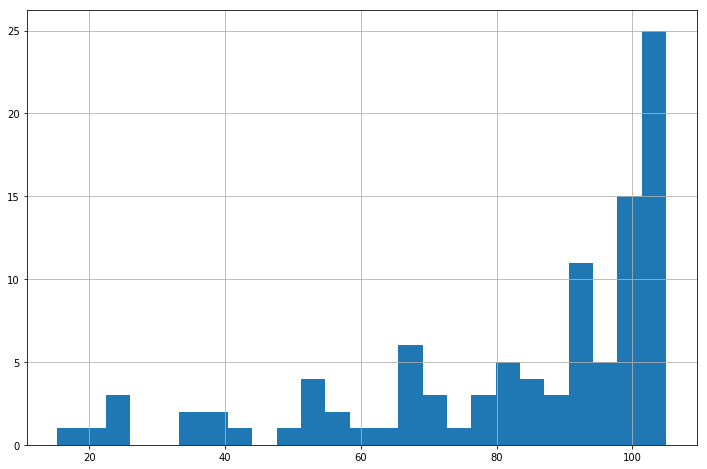

In [50]:
df_gen.Pt0.hist(bins=25)

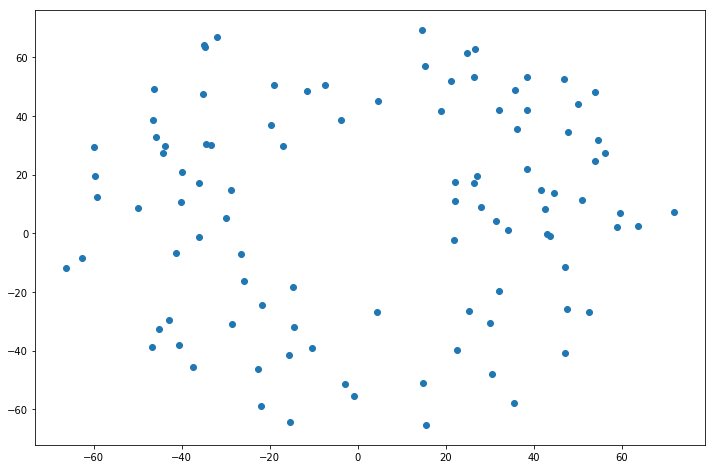

In [51]:
plt.scatter(x=df_gen.X0,y=df_gen.Y0)

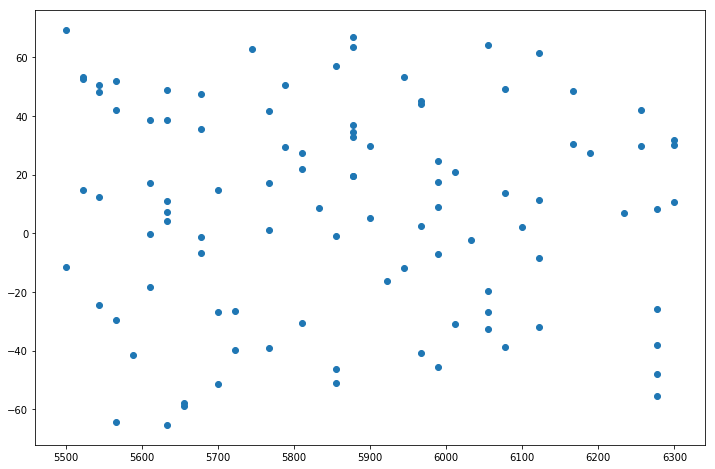

In [52]:
plt.scatter(x=df_gen.Z0,y=df_gen.Y0)

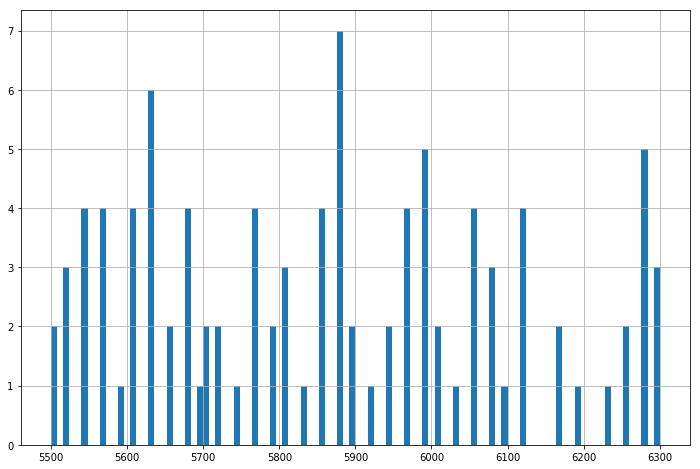

In [53]:
df_gen.Z0.hist(bins=100)

In [54]:
df_gen

,X0,Y0,Z0,Phi0,CosTheta0,Theta0,Px0,Py0,Pz0,Pt0
0,47.914551,34.364830,5877.738281,5.201865,0.660215,0.849692,37.078546,-69.602915,69.322548,78.863074
1,26.714111,62.895973,5744.490234,1.294250,0.979205,0.204290,5.816079,20.492195,102.816551,21.301569
2,-36.165039,-1.440036,5677.785645,0.940786,0.842881,0.568182,33.287485,45.653648,88.502473,56.500551
3,15.276367,56.899105,5855.554199,0.019710,0.886331,0.481436,48.611034,0.958256,93.064757,48.620478
4,43.007080,-0.291426,5611.110840,3.690194,-0.778492,2.463056,-56.232658,-34.368391,-81.741678,65.903703
5,38.430420,41.887730,6255.591309,1.066239,0.911901,0.422904,20.832031,37.723172,95.749615,43.093053
6,-14.714355,-18.385866,5611.068359,3.715211,0.450162,1.103850,-78.752579,-50.880888,47.266971,93.759445
7,-60.064453,29.403732,5788.882812,0.931886,-0.061570,1.632405,62.494907,84.128428,-6.464843,104.800791
8,30.176270,-30.620533,5811.096680,1.006364,-0.400496,1.982854,51.466936,81.288246,-42.052057,96.211353
9,-15.492432,-64.316803,5566.641113,4.697493,0.082756,1.487946,-1.558635,-104.628226,8.689358,104.639835


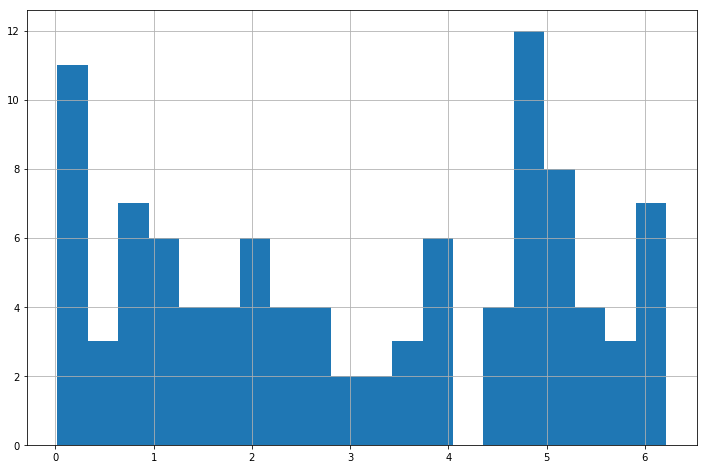

In [55]:
df_gen.Phi0.hist(bins=20)

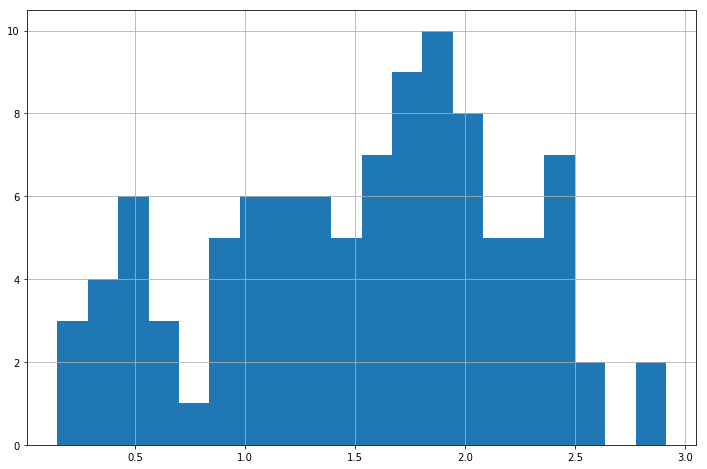

In [56]:
df_gen.Theta0.hist(bins=20)

Let's also dump the generating dataframe to pickle:

In [57]:
save_dir = "/home/ckampa/Coding/Mu2E_Extras/trajectory/run04/"
plot_dir = "/home/ckampa/Coding/Mu2E_Extras/plots/trajectory/run04/"
run_name = "trajectory_run04_"

In [58]:
pkl.dump(df_gen, open(save_dir+run_name+'INIT_COND.p','wb'))

Now we are ready to go!

In [59]:
#timesteps = np.linspace(0,4e-8,4000)
timesteps = np.linspace(0,8e-8,8000)

In [60]:
df_gen.head()

,X0,Y0,Z0,Phi0,CosTheta0,Theta0,Px0,Py0,Pz0,Pt0
0,47.914551,34.364830,5877.738281,5.201865,0.660215,0.849692,37.078546,-69.602915,69.322548,78.863074
1,26.714111,62.895973,5744.490234,1.294250,0.979205,0.204290,5.816079,20.492195,102.816551,21.301569
2,-36.165039,-1.440036,5677.785645,0.940786,0.842881,0.568182,33.287485,45.653648,88.502473,56.500551
3,15.276367,56.899105,5855.554199,0.019710,0.886331,0.481436,48.611034,0.958256,93.064757,48.620478
4,43.007080,-0.291426,5611.110840,3.690194,-0.778492,2.463056,-56.232658,-34.368391,-81.741678,65.903703


## Old Method

In [91]:
start = time.time()
for i,row in tqdm_notebook(enumerate(df_gen.iloc[[4]].itertuples()), desc='particle #'):
    #print (i, row.X0)
    mom = np.array([row.Px0,row.Py0,row.Pz0])
    pos = np.array([row.X0,row.Y0,row.Z0])
    rtol = 1e-8#1e-5
    atol = 1e-8#1e-3
    swimmer = ElectronSwimmer(mom,pos,df_interp,timesteps,'Dop853',rtol=rtol,atol=atol)
    swimmer_x = ElectronSwimmer(mom,pos,df_x_interp,timesteps,'Dop853',rtol=rtol,atol=atol)
    swimmer_y = ElectronSwimmer(mom,pos,df_y_interp,timesteps,'Dop853',rtol=rtol,atol=atol)
    swimmer_z = ElectronSwimmer(mom,pos,df_z_interp,timesteps,'Dop853',rtol=rtol,atol=atol)
    #swimmer = ElectronSwimmer(mom,pos,mag_field_func,timesteps,'Dop853',rtol=rtol,atol=atol)
    X_, t_ = swimmer.solve()
    X_x, t_x = swimmer_x.solve()
    X_y, t_y = swimmer_y.solve()
    X_z, t_z = swimmer_z.solve()
    
    for X,t,shift in zip([X_,X_x,X_y,X_z],[t_,t_x,t_y,t_z],["NONE", "X","Y","Z"]):
        df_out = pd.DataFrame(X,columns=['X','Y','Z','Vx','Vy','Vz'])
        df_out['time'] = t
        df_out['event'] = i
        df_out.event = df_out.event.astype('category')
        df_out['E0'] = swimmer.init_E
        df_out['EF'] = swimmer.final_E
        df_out['B_shift'] = shift
        pkl.dump(df_out,open(save_dir+run_name+f"{i:03d}_Bshift-{shift}_TESTING.p",'wb'))
stop = time.time()

swimming electron with [ 93.76687571 -13.81555071 -45.18742721] MeV, starting at [ -33.54223633   50.5324173  5899.95263672] mm, for 8e-08 s
Dop853 terminated at t=7.27291e-08
init energy: 105.00124342646296 MeV
final energy: 105.00128387273574 MeV
energy difference: 4.044627277721702e-05 MeV (3.852e-05%)
swimming electron with [ 93.76687571 -13.81555071 -45.18742721] MeV, starting at [ -33.54223633   50.5324173  5899.95263672] mm, for 8e-08 s
Dop853 terminated at t=7.40693e-08
init energy: 105.00124342646296 MeV
final energy: 105.00128501540607 MeV
energy difference: 4.158894310535288e-05 MeV (3.961e-05%)
swimming electron with [ 93.76687571 -13.81555071 -45.18742721] MeV, starting at [ -33.54223633   50.5324173  5899.95263672] mm, for 8e-08 s
Dop853 terminated at t=7.30391e-08
init energy: 105.00124342646296 MeV
final energy: 105.00128404377945 MeV
energy difference: 4.061731648619116e-05 MeV (3.868e-05%)
swimming electron with [ 93.76687571 -13.81555071 -45.18742721] MeV, starting a

In [92]:
stop-start

154.79652905464172

In [62]:
stop-start

67.321768283844

In [95]:
# testing it all worked for 1
df_out = pkl.load(open(save_dir+run_name+'000_Bshift-NONE_TESTING.p','rb'))
df_out_x = pkl.load(open(save_dir+run_name+'000_Bshift-X_TESTING.p','rb'))
df_out_y = pkl.load(open(save_dir+run_name+'000_Bshift-Y_TESTING.p','rb'))
df_out_z = pkl.load(open(save_dir+run_name+'000_Bshift-Z_TESTING.p','rb'))

In [96]:
df_out

,X,Y,Z,Vx,Vy,Vz,time,event,E0,EF,B_shift
0,-33.542236,50.532417,5899.952637,2.677169e+11,-3.944523e+10,-1.290161e+11,0.000000e+00,0,105.001243,105.001284,NONE
1,-30.862340,50.154864,5898.662250,2.681883e+11,-3.605490e+10,-1.290290e+11,1.000125e-11,0,105.001243,105.001284,NONE
2,-28.177943,49.811252,5897.371735,2.686169e+11,-3.265770e+10,-1.290419e+11,2.000250e-11,0,105.001243,105.001284,NONE
3,-25.489473,49.501649,5896.081088,2.690026e+11,-2.925415e+10,-1.290551e+11,3.000375e-11,0,105.001243,105.001284,NONE
4,-22.797363,49.226115,5894.790310,2.693452e+11,-2.584481e+10,-1.290683e+11,4.000500e-11,0,105.001243,105.001284,NONE
5,-20.102041,48.984706,5893.499399,2.696446e+11,-2.243022e+10,-1.290816e+11,5.000625e-11,0,105.001243,105.001284,NONE
6,-17.403940,48.777470,5892.208355,2.699008e+11,-1.901092e+10,-1.290950e+11,6.000750e-11,0,105.001243,105.001284,NONE
7,-14.703494,48.604454,5890.917176,2.701137e+11,-1.558746e+10,-1.291085e+11,7.000875e-11,0,105.001243,105.001284,NONE
8,-12.001136,48.465694,5889.625862,2.702832e+11,-1.216038e+10,-1.291220e+11,8.001000e-11,0,105.001243,105.001284,NONE
9,-9.297299,48.361226,5888.334412,2.704093e+11,-8.730248e+09,-1.291356e+11,9.001125e-11,0,105.001243,105.001284,NONE


In [97]:
from hallprobecalib.hpcplots import scatter2d, scatter3d, histo

In [99]:
fig = scatter3d([df[::10].X for df in [df_out,df_out_x,df_out_y,df_out_z]],
          [df[::10].Y for df in [df_out,df_out_x,df_out_y,df_out_z]],
          [df[::10].Z for df in [df_out,df_out_x,df_out_y,df_out_z]],
          scale_list=[df[::10].time for df in [df_out,df_out_x,df_out_y,df_out_z]],
          mode_list=4*['markers+lines'],units_list=4*[('mm','mm','mm')],inline=True, 
          colors_list = ["Viridis","Hot","Jet","Picnic"]
         );

In [69]:
for df in [df_out,df_out_x,df_out_y,df_out_z]:
    print(df.tail(1))

               X           Y             Z            Vx            Vy  \
4176  332.269398  521.795732  12001.338396 -2.171361e+11  1.038238e+11   

                Vz          time event          E0          EF B_shift  
4176  1.787342e+11  4.176522e-08     0  105.001243  105.001256    NONE  
               X           Y             Z            Vx            Vy  \
4130  391.987462  469.568023  12001.597997 -1.746662e+11  1.621803e+11   

                Vz          time event          E0          EF B_shift  
4130  1.818314e+11  4.130516e-08     0  105.001243  105.001256       X  
               X           Y             Z            Vx            Vy  \
4148  393.622315  474.890296  12000.838216 -1.834465e+11  1.541398e+11   

                Vz          time event          E0          EF B_shift  
4148  1.801713e+11  4.148519e-08     0  105.001243  105.001256       Y  
               X           Y             Z            Vx            Vy  \
4176  332.269398  521.795732  12001.33839

In [100]:
plot(fig)

'file:///home/ckampa/Coding/Mu2E/scripts/ColeTests/temp-plot.html'

In [60]:
scatter3d([df[::10].X for df in [df_out,df_out_x]],
          [df[::10].Y for df in [df_out,df_out_x]],
          [df[::10].Z for df in [df_out,df_out_x]],
          scale_list=[df[::10].time for df in [df_out,df_out_x]],
          mode_list=2*['markers+lines'],units_list=2*[('mm','mm','mm')],inline=True, 
          colors_list = ["Viridis","Hot"]
         );

In [31]:
scatter3d(df_out.X,df_out.Y,df_out.Z,scale_list=[df_out.time],mode_list=['markers+lines'],units_list=[('mm','mm','mm')],inline=True)

Figure({
    'data': [{'marker': {'cauto': False,
                         'cmax': 4e-08,
                         'cmin': 0.0,
                         'color': array([0.00000000e+00, 1.00025006e-11, 2.00050013e-11, ..., 3.99799950e-08,
                                         3.99899975e-08, 4.00000000e-08]),
                         'colorbar': {'thickness': 20, 'title': 'time (mm)', 'x': -0.1, 'y': 0.5},
                         'colorscale': 'Viridis',
                         'opacity': 0.8,
                         'reversescale': False,
                         'showscale': True,
                         'size': 2},
              'mode': 'markers+lines',
              'name': '<br>x: X (mm)<br>y: Y (mm)<br>z: Z (mm)<br>',
              'type': 'scatter3d',
              'uid': 'cecb65f5-9129-490d-8709-d6e71459b0d6',
              'x': array([-23.57373047, -21.01726607, -18.44129515, ...,  77.04929463,
                           79.98150141,  82.91537939]),
              'y': ar

Great! But this takes far too long...bottlenecked by B-field calculation.

In [32]:
%timeit mag_field_func(10,10,6000)

2.01 ms ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Goal: beat this down by a factor of 10.

In [10]:
df_out = pkl.load(open(save_dir+run_name+'000_TESTING.p','rb'))

In [11]:
df_out.eval('R = (X**2+Y**2)**(1/2)',inplace=True)

In [14]:
df_small = df_out[::10]

In [15]:
df_small

,X,Y,Z,Vx,Vy,Vz,time,event,E0,EF,R
0,-23.573730,-52.282639,5788.937012,2.545934e+11,-1.542701e+11,3.544451e+10,0.000000e+00,0,105.001243,105.535045,57.351504
10,2.816048,-66.027968,5792.486285,2.723335e+11,-1.201915e+11,3.552221e+10,1.000250e-10,0,105.001243,105.535045,66.087992
20,30.755000,-76.261180,5796.042973,2.855288e+11,-8.414201e+10,3.559247e+10,2.000500e-10,0,105.001243,105.535045,82.229177
30,59.777532,-82.814843,5799.606342,2.939713e+11,-4.672125e+10,3.565625e+10,3.000750e-10,0,105.001243,105.535045,102.135457
40,89.401070,-85.582784,5803.175886,2.975308e+11,-8.551517e+09,3.571640e+10,4.001000e-10,0,105.001243,105.535045,123.761723
50,119.134029,-84.521723,5806.751368,2.961578e+11,2.973376e+10,3.577530e+10,5.001250e-10,0,105.001243,105.535045,146.071347
60,148.483954,-79.651819,5810.332747,2.898842e+11,6.750124e+10,3.583454e+10,6.001500e-10,0,105.001243,105.535045,168.498952
70,176.965662,-71.056176,5813.920114,2.788232e+11,1.041275e+11,3.589516e+10,7.001750e-10,0,105.001243,105.535045,190.698258
80,204.109236,-58.879294,5817.513643,2.631665e+11,1.390101e+11,3.595784e+10,8.002001e-10,0,105.001243,105.535045,212.431993
90,229.467750,-43.324503,5821.113562,2.431817e+11,1.715763e+11,3.602298e+10,9.002251e-10,0,105.001243,105.535045,233.521864


In [16]:
df = df_small
scatter3d(df.X,df.Y,df.Z,scale_list=[df.time],mode_list=['markers+lines'],units_list=[('mm','mm','mm')],inline=True)

Figure({
    'data': [{'marker': {'cauto': False,
                         'cmax': 3.990997749437359e-08,
                         'cmin': 0.0,
                         'color': array([0.00000000e+00, 1.00025006e-10, 2.00050013e-10, ..., 3.97099275e-08,
                                         3.98099525e-08, 3.99099775e-08]),
                         'colorbar': {'thickness': 20, 'title': 'time (mm)', 'x': -0.1, 'y': 0.5},
                         'colorscale': 'Viridis',
                         'opacity': 0.8,
                         'reversescale': False,
                         'showscale': True,
                         'size': 2},
              'mode': 'markers+lines',
              'name': '<br>x: X (mm)<br>y: Y (mm)<br>z: Z (mm)<br>',
              'type': 'scatter3d',
              'uid': '2b4c1028-cac2-49ea-a996-42daf29243ea',
              'x': array([-23.57373047,   2.81604756,  30.75499985, ...,  -0.54512077,
                           27.70835526,  56.5924291 ]),
     

In [17]:
df_small.head(1)

,X,Y,Z,Vx,Vy,Vz,time,event,E0,EF,R
0,-23.57373,-52.282639,5788.937012,2.545934e+11,-1.542701e+11,3.544451e+10,0.0,0,105.001243,105.535045,57.351504


In [18]:
(df_small.head(1).EF-df_small.head(1).E0)/df_small.head(1).E0

0    0.005084
dtype: float64

In [22]:
mom = [89.17044479,-54.03255115,12.41431398]
p = np.sqrt(np.dot(mom,mom))
pt = np.sqrt(mom[0]**2+mom[1]**2)

In [21]:
p

104.99999999722775

In [23]:
pt

104.26353536986842

## Multiprocessing Method (using joblib)
- Test of 10 particles (x 4 trajectory calculations per particle) yielded ~20s per particle or ~5s per track calculation.

In [2]:
from joblib import Parallel, delayed
import multiprocessing

In [3]:
num_cores = multiprocessing.cpu_count()

In [4]:
num_cores

8

In [63]:
rtol = 1e-8#1e-5
atol = 1e-8#1e-3

def calc_track(row, i):
    mom = np.array([row.Px0,row.Py0,row.Pz0])
    pos = np.array([row.X0,row.Y0,row.Z0])
    print(f"Start {i}: {mom}, {pos}")
    swimmer = ElectronSwimmer(mom,pos,df_interp,timesteps,'Dop853',rtol=rtol,atol=atol)
    swimmer_x = ElectronSwimmer(mom,pos,df_x_interp,timesteps,'Dop853',rtol=rtol,atol=atol)
    swimmer_y = ElectronSwimmer(mom,pos,df_y_interp,timesteps,'Dop853',rtol=rtol,atol=atol)
    swimmer_z = ElectronSwimmer(mom,pos,df_z_interp,timesteps,'Dop853',rtol=rtol,atol=atol)
    #swimmer = ElectronSwimmer(mom,pos,mag_field_func,timesteps,'Dop853',rtol=rtol,atol=atol)
    X_, t_ = swimmer.solve()
    X_x, t_x = swimmer_x.solve()
    X_y, t_y = swimmer_y.solve()
    X_z, t_z = swimmer_z.solve()
    
    for X,t,shift in zip([X_,X_x,X_y,X_z],[t_,t_x,t_y,t_z],["NONE", "X","Y","Z"]):
        df_out = pd.DataFrame(X,columns=['X','Y','Z','Vx','Vy','Vz'])
        df_out['time'] = t
        df_out['event'] = i
        df_out.event = df_out.event.astype('category')
        df_out['E0'] = swimmer.init_E
        df_out['EF'] = swimmer.final_E
        df_out['B_shift'] = shift
        pkl.dump(df_out,open(save_dir+run_name+f"{i:03d}_Bshift-25mm-{shift}.p",'wb'))
    print(f"End {i}")

In [64]:
#N2 = 10

start = time.time()
Parallel(n_jobs=num_cores)(delayed(calc_track)(row,i) for i,row in tqdm_notebook(enumerate(
    df_gen.itertuples()), desc='particle #'))#.sample(N2).itertuples()), desc='particle #'))
stop = time.time()

In [65]:
stop - start

1771.8467400074005

In [68]:
(stop - start) / 100 / 4

4.429616850018501

In [42]:
193.9/10/4

4.8475